In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.listdir('/content/drive/My Drive/DATASETv7')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/DATASETv7'

In [ ]:
TRAIN_DIR = '/content/drive/My Drive/DATASETv7/TRAIN/'
VALIDATION_DIR = '/content/drive/My Drive/DATASETv7/VALIDATION'

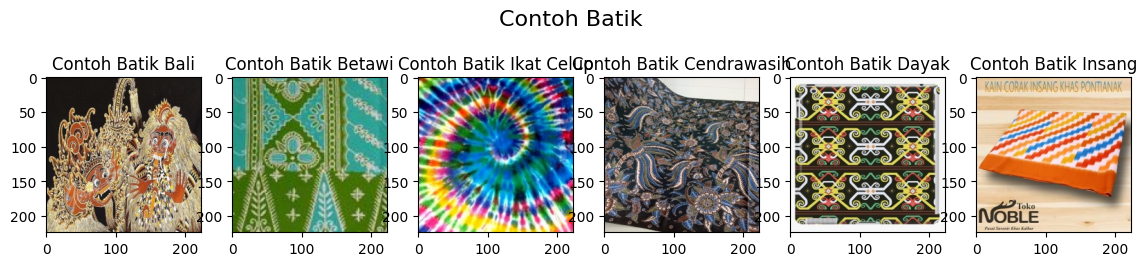

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(14, 3))
fig.suptitle('Contoh Batik', fontsize=16)

# Plot one image from the first 6 letters
for ii, letter in enumerate(['Batik Bali','Batik Betawi','Batik Ikat Celup','Batik Cendrawasih','Batik Dayak','Batik Insang']):
    dir = f'{TRAIN_DIR}/{letter}'
    img = tf.keras.preprocessing.image.load_img(dir + '/' + os.listdir(dir)[0])
    axes[ii].imshow(img)
    axes[ii].set_title(f'Contoh {letter}')

In [ ]:
sample_array = tf.keras.preprocessing.image.img_to_array(img)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (224, 224, 3)


In [ ]:
def train_val_datasets():
    # Data augmentation for training data
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    # No augmentation for validation data, only rescaling
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Example usage with training data
    train_dataset = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(256, 256),
        batch_size=16,
        class_mode='categorical',
        color_mode = "rgb"
    )

    # Example usage with validation data
    validation_dataset = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(256, 256),
        batch_size=16,
        class_mode='categorical',
        color_mode = "rgb"
    )

    return train_dataset, validation_dataset

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Load the VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(train_dataset.num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Define the learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
train_dataset, validation_dataset = train_val_datasets()
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=[lr_scheduler]
)

Found 1050 images belonging to 15 classes.
Found 300 images belonging to 15 classes.
Epoch 1/100
66/66 [==============================] - 43s 620ms/step - loss: 2.8849 - accuracy: 0.2410 - val_loss: 7.1003 - val_accuracy: 0.1567 - lr: 0.0010
Epoch 2/100
66/66 [==============================] - 40s 599ms/step - loss: 2.2485 - accuracy: 0.3610 - val_loss: 2.3312 - val_accuracy: 0.4467 - lr: 0.0010
Epoch 3/100
66/66 [==============================] - 40s 601ms/step - loss: 1.9931 - accuracy: 0.4019 - val_loss: 1.6007 - val_accuracy: 0.5267 - lr: 0.0010
Epoch 4/100
66/66 [==============================] - 39s 595ms/step - loss: 1.8294 - accuracy: 0.4495 - val_loss: 1.6199 - val_accuracy: 0.5033 - lr: 0.0010
Epoch 5/100
66/66 [==============================] - 39s 595ms/step - loss: 1.6866 - accuracy: 0.5057 - val_loss: 1.3623 - val_accuracy: 0.5800 - lr: 0.0010
Epoch 6/100
66/66 [==============================] - 39s 595ms/step - loss: 1.6100 - accuracy: 0.5095 - val_loss: 1.2418 - val_acc

KeyboardInterrupt: 

In [ ]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to a .tflite file
tflite_model_path = '/content/drive/My Drive/DATASETv7/model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model has been converted and saved to {tflite_model_path}")